In [1]:
# reff : https://www.kaggle.com/code/jonathandavidmartin/jpx-stock-analysis-prediction

#### Data Project - Stock Market Analysis 

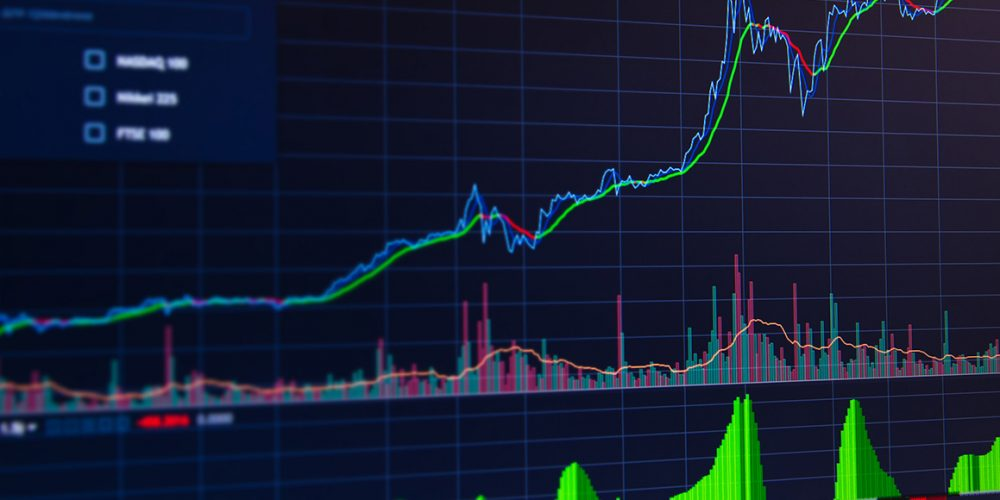

In this notebook we will be looking at data from the stock market, particularly some technology stocks. We will learn how to use pandas to get stock information, visualize different aspects of it, and finally we will look at a few ways of analyzing the risk of a stock, based on its previous performance history. We will also be predicting future stock prices through a Long Short Term Memory (LSTM) method!

We'll be answering the following questions along the way:

    1.) What was the change in price of the stock over time?
    2.) What was the daily return of the stock on average?
    3.) What was the moving average of the various stocks?
    4.) What was the correlation between different stocks'?
    5.) How much value do we put at risk by investing in a particular stock?
    6.) How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM)
   

# 1. What was the change in price of the stock overtime?

In this section we'll go over how to handle requesting stock information with pandas, and how to analyze basic attributes of a stock.

In [2]:
# !pip install -q hvplot
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader
#!pip install -q yfinance


In [3]:
import pandas as pd
import numpy as np
import os


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

print("Using TensorFlow version %s" % tf.__version__)

Using TensorFlow version 2.5.0


In [4]:
"""
!pip install opendatasets --quiet
import opendatasets as od
kaggle_url = "https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction"
od.download(kaggle_url)
"""



'\n!pip install opendatasets --quiet\nimport opendatasets as od\nkaggle_url = "https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction"\nod.download(kaggle_url)\n'

In [5]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
#tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN','TSLA']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Quick note: Using globals() is a sloppy way of setting the DataFrame names, but its simple

Let's go ahead and play aorund with the AAPL DataFrame to get a feel for the data

In [6]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df #.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2021-05-20,125.230003,127.720001,125.099998,127.309998,126.586777,76857100,APPLE
2021-05-21,127.820000,128.000000,125.209999,125.430000,124.717468,79295400,APPLE
2021-05-24,126.010002,127.940002,125.940002,127.099998,126.377968,63092900,APPLE
2021-05-25,127.820000,128.320007,126.320000,126.900002,126.179108,72009500,APPLE
2021-05-26,126.959999,127.389999,126.419998,126.849998,126.129395,56575900,APPLE
...,...,...,...,...,...,...,...
2022-05-16,2262.000000,2279.850098,2207.080078,2216.209961,2216.209961,3728300,AMAZON
2022-05-17,2265.500000,2316.000000,2225.530029,2307.370117,2307.370117,3822400,AMAZON
2022-05-18,2228.790039,2257.060059,2124.979980,2142.250000,2142.250000,5419000,AMAZON


In [7]:
for company, company_name in zip(company_list, tech_list):
     company["company_name"] = company_name

In [8]:
#base_dir="../input/jpx-tokyo-stock-exchange-prediction/"
base_dir="JPX Tokyo Stock Exchange Prediction/"

os.listdir(base_dir)

['data_specifications',
 'example_test_files',
 'jpx_tokyo_market_prediction',
 'stock_list.csv',
 'supplemental_files',
 'train_files']

In [9]:

# There are three types of folders.
# We use stock_price.csv in the train_files folder to check our model in public leaderboard in this notebook.
train_files_dir = f"{base_dir}/train_files"
train_files_dir

'JPX Tokyo Stock Exchange Prediction//train_files'

In [10]:
df_price_raw = pd.read_csv(f"{train_files_dir}/stock_prices.csv")
df_price_raw

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [11]:
df_stock_list = pd.read_csv(base_dir + "/stock_list.csv")
df_stock_list

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False
3,1308,20211230,Nikko Exchange Traded Index Fund TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2053.0,3.736943e+09,7.671945e+12,False
4,1309,20211230,NEXT FUNDS ChinaAMC SSE50 Index Exchange Trade...,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,44280.0,7.263200e+04,3.216145e+09,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,9994,20211230,YAMAYA CORPORATION,First Section (Domestic),Standard Market,6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,20211230.0,2447.0,1.084787e+07,2.654474e+10,True
4413,9995,20211230,"GLOSEL Co.,Ltd.",First Section (Domestic),Prime Market,6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,20211230.0,410.0,2.642680e+07,1.083499e+10,False
4414,9996,20211230,"Satoh&Co.,Ltd.",JASDAQ(Standard / Domestic),Standard Market,6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,-,-,20211230.0,1488.0,9.152640e+06,1.361913e+10,False
4415,9997,20211230,"BELLUNA CO.,LTD.",First Section (Domestic),Prime Market,6100,Retail Trade,14,RETAIL TRADE,6,TOPIX Small 1,20211230.0,709.0,9.724447e+07,6.894633e+10,True


In [12]:
df_stock_list['33SectorName'].unique()

array(['Fishery, Agriculture and Forestry', '-', 'Wholesale Trade',
       'Construction', 'Nonferrous Metals', 'Mining', 'Services',
       'Machinery', 'Metal Products', 'Information & Communication',
       'Foods', 'Pharmaceutical', 'Real Estate', 'Land Transportation',
       'Other Financing Business', 'Retail Trade', 'Other Products',
       'Chemicals', 'Textiles and Apparels', 'Electric Appliances',
       'Glass and Ceramics Products',
       'Securities and Commodities Futures', 'Transportation Equipment',
       'Oil and Coal Products', 'Pulp and Paper', 'Precision Instruments',
       'Rubber Products', 'Iron and Steel', 'Banks', 'Insurance',
       'Warehousing and Harbor Transportation Service',
       'Marine Transportation', 'Air Transportation',
       'Electric Power and Gas'], dtype=object)

In [13]:
df_stock_list[df_stock_list['Name'].str.startswith("Nin")==True]

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
3535,7974,20211230,"Nintendo Co.,Ltd.",First Section (Domestic),Prime Market,3800,Other Products,10,"IT & SERVICES, OTHERS",1,TOPIX Core30,20211230.0,53650.0,129869000.0,6.967472e+12,True


In [14]:
df_nintendo = df_price_raw[df_price_raw['SecuritiesCode']==7974]
df_nintendo

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1392,20170104_7974,2017-01-04,7974,24540.0,24545.0,24330.0,24480.0,1437600,1.0,NaN,False,-0.001453
3257,20170105_7974,2017-01-05,7974,24555.0,24840.0,23875.0,24085.0,2546200,1.0,NaN,False,0.013306
5122,20170106_7974,2017-01-06,7974,24000.0,24215.0,23920.0,24050.0,1443500,1.0,NaN,False,0.031801
6987,20170110_7974,2017-01-10,7974,24490.0,24530.0,24185.0,24370.0,1725900,1.0,NaN,False,0.002187
8852,20170111_7974,2017-01-11,7974,24650.0,25350.0,24580.0,25145.0,3224400,1.0,NaN,False,-0.057540
...,...,...,...,...,...,...,...,...,...,...,...,...
2324046,20211129_7974,2021-11-29,7974,50180.0,52040.0,50070.0,51340.0,1304100,1.0,NaN,False,0.011377
2326046,20211130_7974,2021-11-30,7974,51530.0,51730.0,50010.0,50100.0,1271300,1.0,NaN,False,0.020328
2328046,20211201_7974,2021-12-01,7974,50100.0,51400.0,49800.0,50670.0,838100,1.0,NaN,False,-0.020116
2330046,20211202_7974,2021-12-02,7974,50740.0,51950.0,50710.0,51700.0,976500,1.0,NaN,False,-0.000395


In [15]:
df_price_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [16]:
df_nintendo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1202 entries, 1392 to 2332046
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RowId             1202 non-null   object 
 1   Date              1202 non-null   object 
 2   SecuritiesCode    1202 non-null   int64  
 3   Open              1201 non-null   float64
 4   High              1201 non-null   float64
 5   Low               1201 non-null   float64
 6   Close             1201 non-null   float64
 7   Volume            1202 non-null   int64  
 8   AdjustmentFactor  1202 non-null   float64
 9   ExpectedDividend  10 non-null     float64
 10  SupervisionFlag   1202 non-null   bool   
 11  Target            1202 non-null   float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 113.9+ KB


In [17]:
price_cols = [
    "Date",
    "SecuritiesCode",
    "Open",
    "High",
    "Low",
    "Close",
    "AdjustmentFactor",
    "Volume"
]
df_nintendo = df_nintendo[price_cols]

# filter data to reduce culculation cost 
df_nintendo = df_nintendo.loc[df_nintendo["Date"] >= "2019-08-01"]

In [18]:
df_nintendo

,Date,SecuritiesCode,Open,High,Low,Close,AdjustmentFactor,Volume
1202045,2019-08-01,7974,40430.0,41810.0,40360.0,41440.0,1.0,2402000
1203990,2019-08-02,7974,40840.0,40980.0,39840.0,40290.0,1.0,2278200
1205935,2019-08-05,7974,39790.0,39850.0,38840.0,39330.0,1.0,1499700
1207880,2019-08-06,7974,37730.0,39010.0,37660.0,38940.0,1.0,1792000
1209825,2019-08-07,7974,39330.0,39430.0,38830.0,39180.0,1.0,1231600
...,...,...,...,...,...,...,...,...
2324046,2021-11-29,7974,50180.0,52040.0,50070.0,51340.0,1.0,1304100
2326046,2021-11-30,7974,51530.0,51730.0,50010.0,50100.0,1.0,1271300
2328046,2021-12-01,7974,50100.0,51400.0,49800.0,50670.0,1.0,838100
2330046,2021-12-02,7974,50740.0,51950.0,50710.0,51700.0,1.0,976500


In [19]:
# Summary Stats
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,254.000000,254.000000,254.000000,254.000000,254.000000,2.540000e+02
mean,154.586733,156.370906,152.911181,154.695118,154.201878,8.820842e+07
std,14.658627,14.979194,14.279805,14.635162,14.758306,2.678946e+07
min,124.070000,124.849998,123.129997,123.540001,122.838203,4.100000e+07
25%,145.139999,146.867496,144.027500,145.639999,145.000195,6.920740e+07
50%,151.735001,154.375000,150.270004,151.945000,151.532249,8.325120e+07
75%,167.457497,169.654995,165.384998,166.524998,166.280693,1.023783e+08
max,182.630005,182.940002,179.119995,182.009995,181.511703,1.954327e+08


In [20]:
# General info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2021-05-20 to 2022-05-20
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          254 non-null    float64
 1   High          254 non-null    float64
 2   Low           254 non-null    float64
 3   Close         254 non-null    float64
 4   Adj Close     254 non-null    float64
 5   Volume        254 non-null    int64  
 6   company_name  254 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.9+ KB


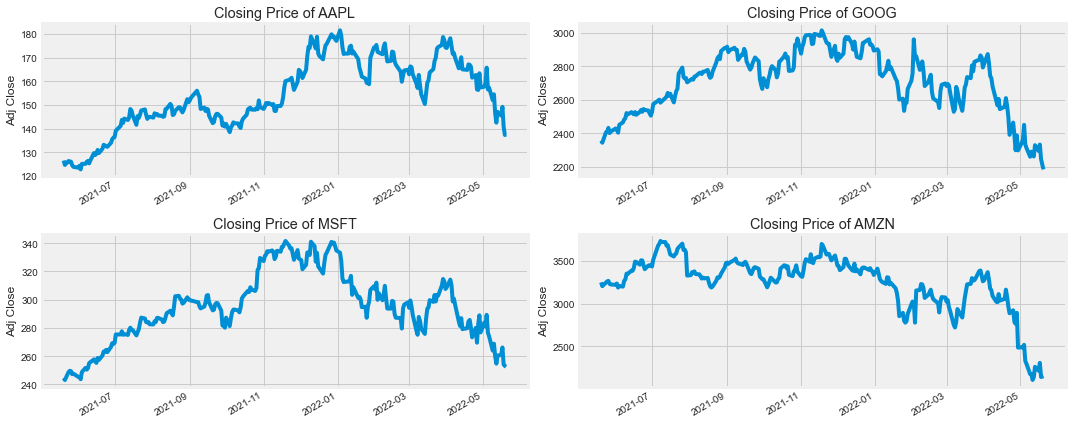

In [21]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

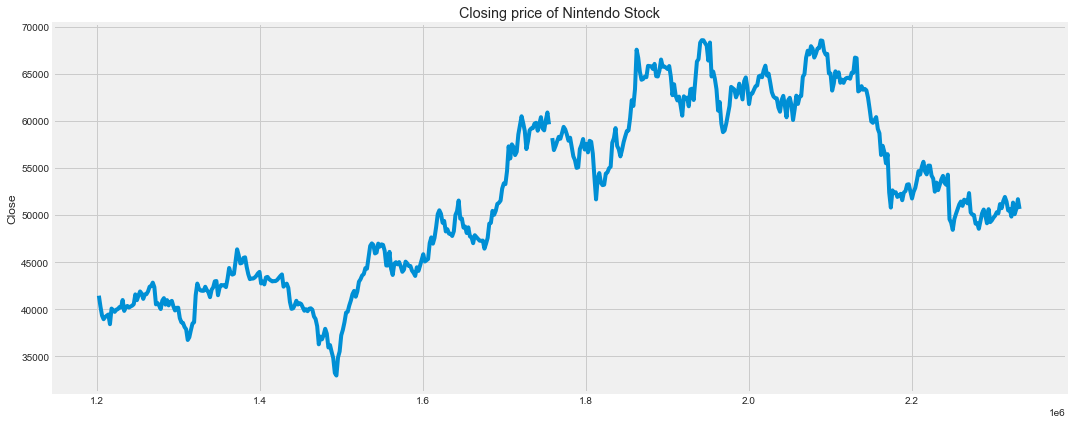

In [22]:
# Let's see a historical view of the closing price


plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

#for i, company in enumerate(company_list, 1):
#plt.subplot(2, 2, i)
df_nintendo['Close'].plot()
plt.ylabel('Close')
plt.xlabel(None)
plt.title("Closing price of Nintendo Stock")
    
plt.tight_layout()

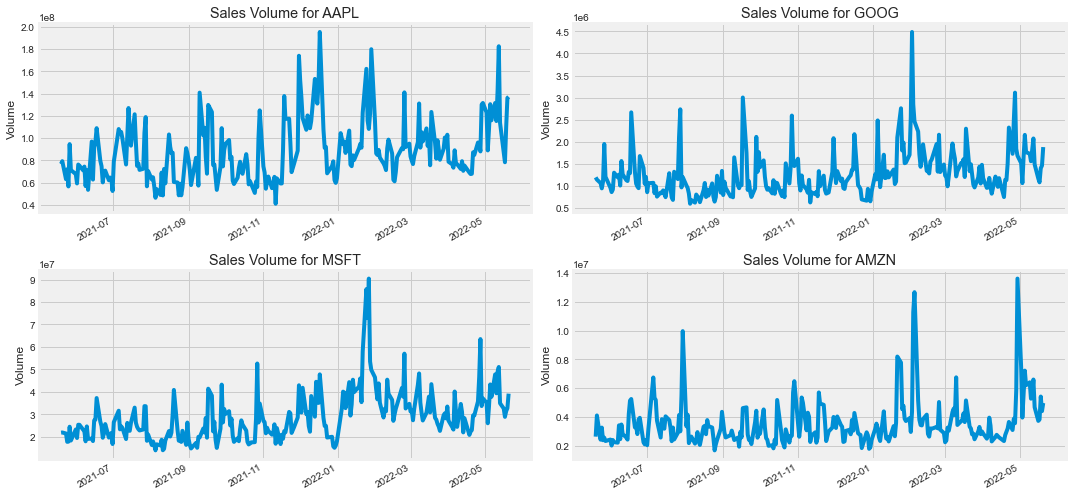

In [23]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 7))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

Now that we've seen the visualizations for the closing price and the volume traded each day, let's go ahead and caculate the moving average for the stock.

# 2. What was the moving average of the various stocks?

In [24]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

In [25]:
print(GOOG.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')


Now let's go ahead and plot all the additional Moving Averages

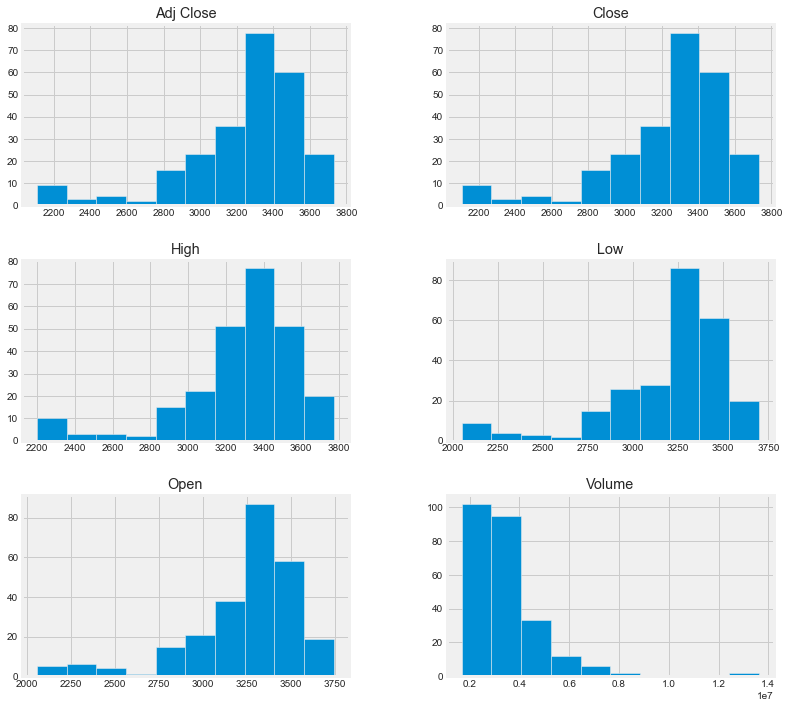

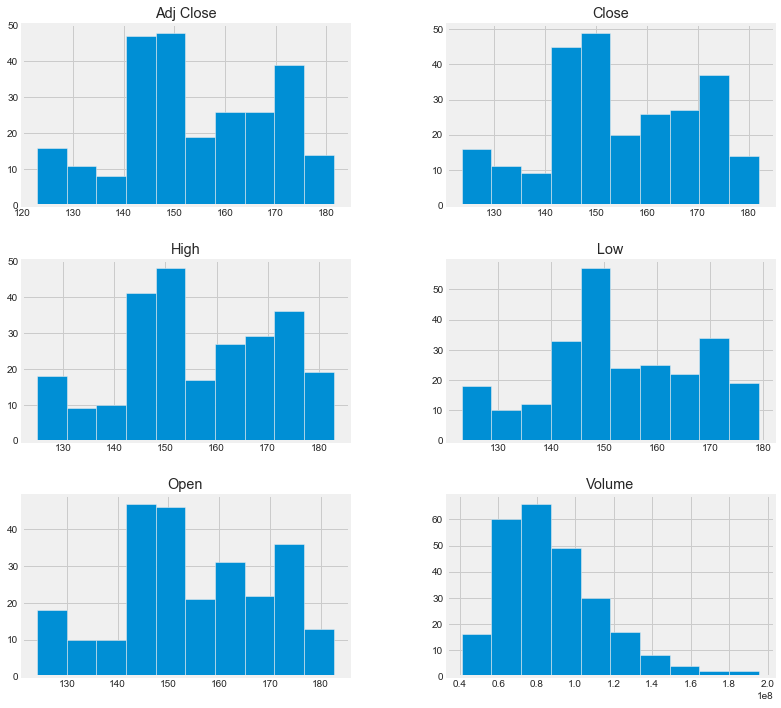

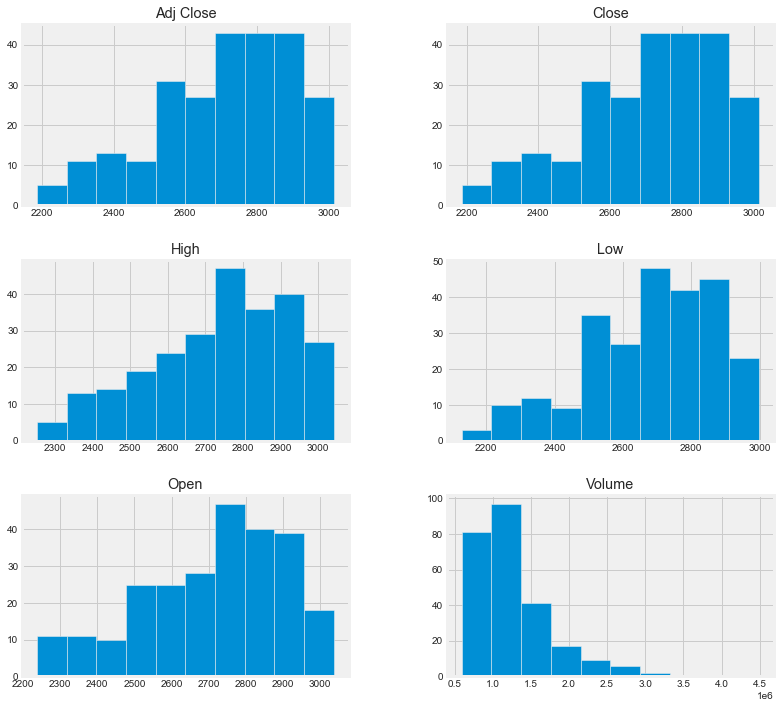

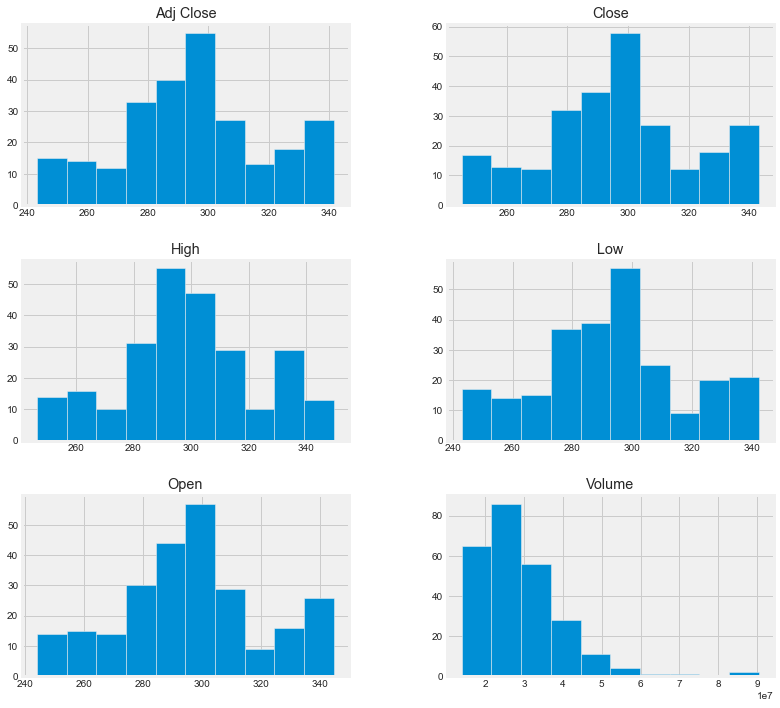

In [26]:
df.groupby("company_name").hist(figsize=(12, 12));

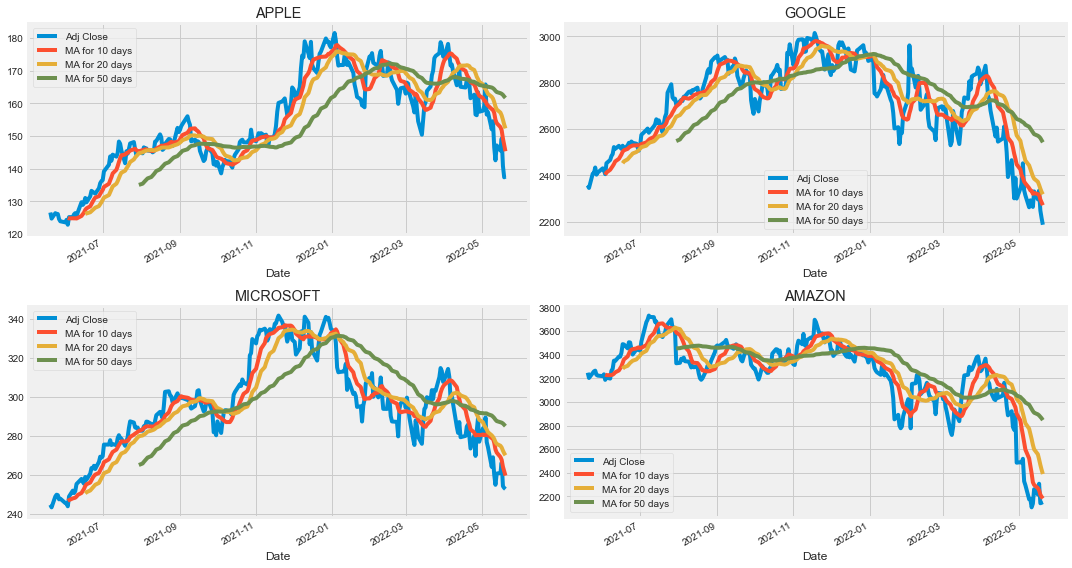

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

# 3. What was the daily return of the stock on average?

Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve teh daily returns for the Apple stock.

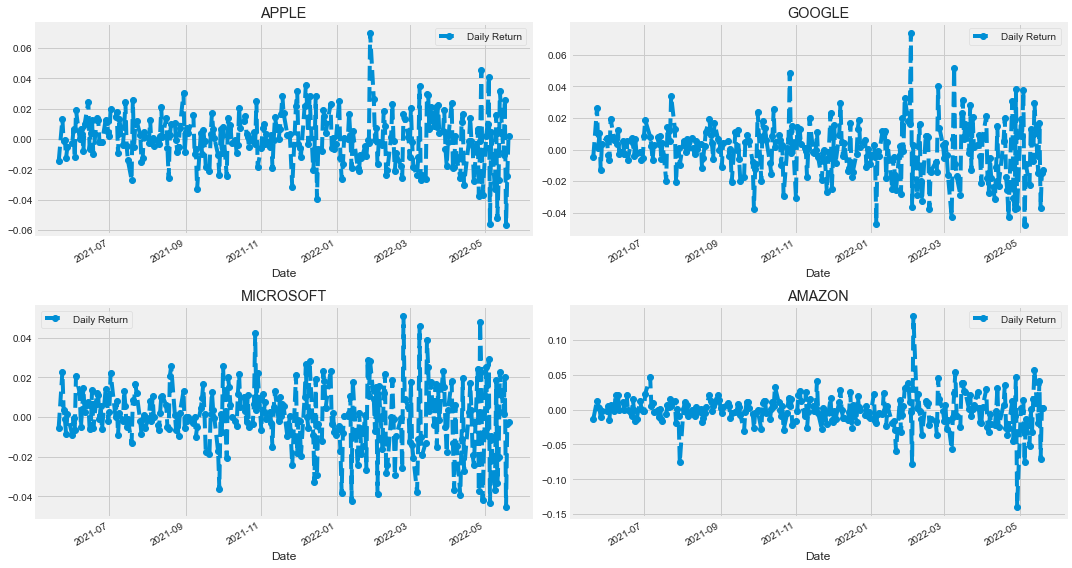

In [28]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

Great, now let's get an overall look at the average daily return using a histogram. We'll use seaborn to create both a histogram and kde plot on the same figure.

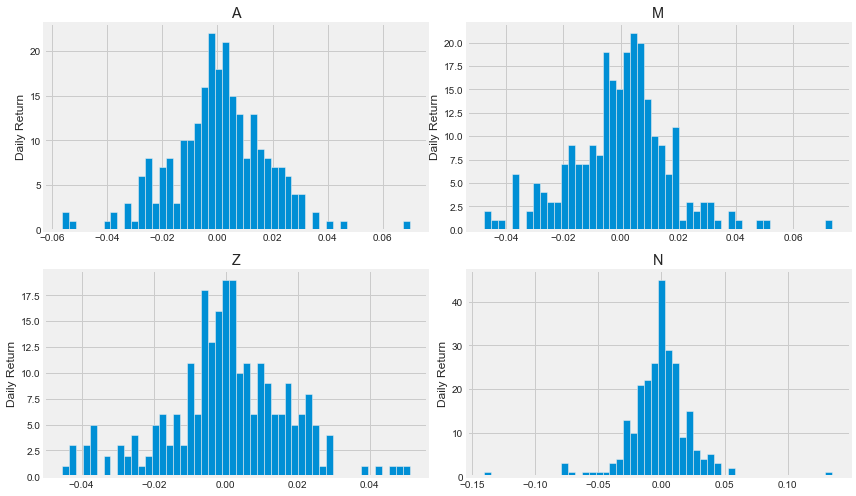

In [29]:
plt.figure(figsize=(12, 7))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.ylabel('Daily Return')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()

# 4. What was the correlation between different stocks closing prices?

Now what if we wanted to analyze the returns of all the stocks in our list? Let's go ahead and build a DataFrame with all the ['Close'] columns for each of the stocks dataframes.

In [30]:
# Grab all the closing prices for the tech stock list into one DataFrame
closing_df = DataReader(tech_list, 'yahoo', start, end)['Adj Close']

# Let's take a quick look
closing_df.head() 

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2021-05-20,126.586777,2356.090088,244.483643,3247.679932
2021-05-21,124.717461,2345.100098,243.184265,3203.080078
2021-05-24,126.377968,2406.669922,248.748840,3244.989990
2021-05-25,126.179115,2409.070068,249.681213,3259.050049
2021-05-26,126.129387,2433.530029,249.453094,3265.159912


Now that we have all the closing prices, let's go ahead and get the daily return for all the stocks, like we did for the Apple stock.

In [31]:
# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2021-05-20,NaN,NaN,NaN,NaN
2021-05-21,-0.014767,-0.004665,-0.005315,-0.013733
2021-05-24,0.013314,0.026255,0.022882,0.013084
2021-05-25,-0.001573,0.000997,0.003748,0.004333
2021-05-26,-0.000394,0.010153,-0.000914,0.001875


Now we can compare the daily percentage return of two stocks to check how correlated. First let's see a sotck compared to itself.

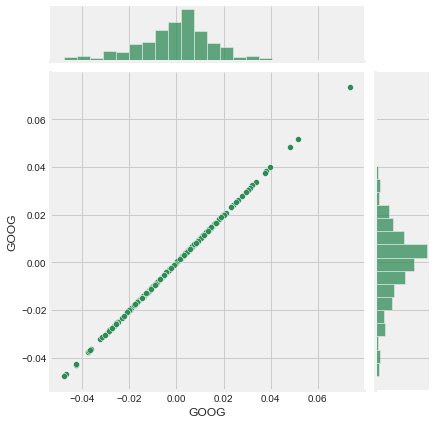

In [32]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

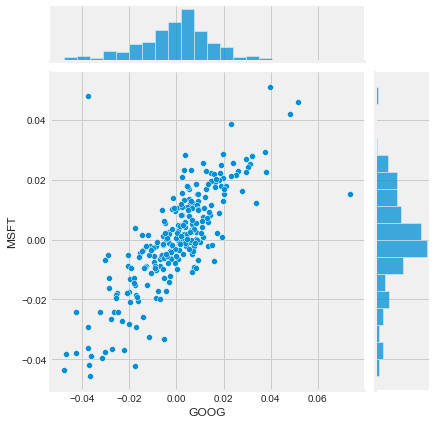

In [33]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

So now we can see that if two stocks are perfectly (and positivley) correlated with each other a linear relationship bewteen its daily return values should occur. 

Seaborn and pandas make it very easy to repeat this comparison analysis for every possible combination of stocks in our technology stock ticker list. We can use sns.pairplot() to automatically create this plot

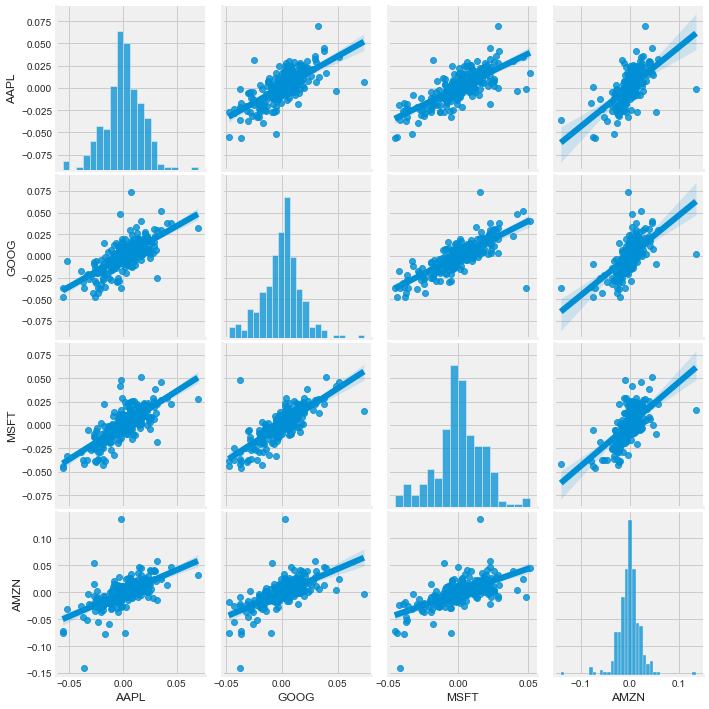

In [34]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis 
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

Above we can see all the relationships on daily returns between all the stocks. A quick glance shows an interesting correlation between Google and Amazon daily returns. It might be interesting to investigate that individual comaprison. While the simplicity of just calling sns.pairplot() is fantastic we can also use sns.PairGrid() for full control of the figure, including what kind of plots go in the diagonal, the upper triangle, and the lower triangle. Below is an example of utilizing the full power of seaborn to achieve this result.

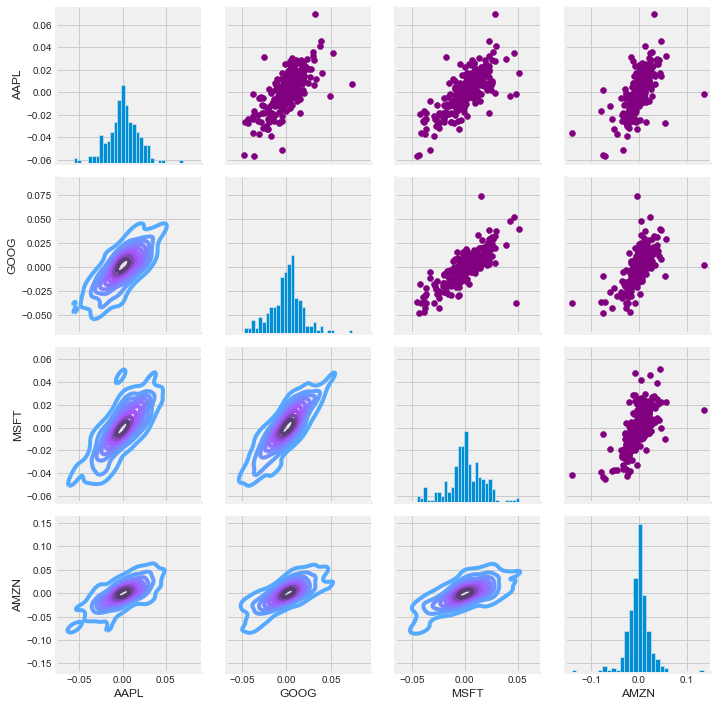

In [35]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

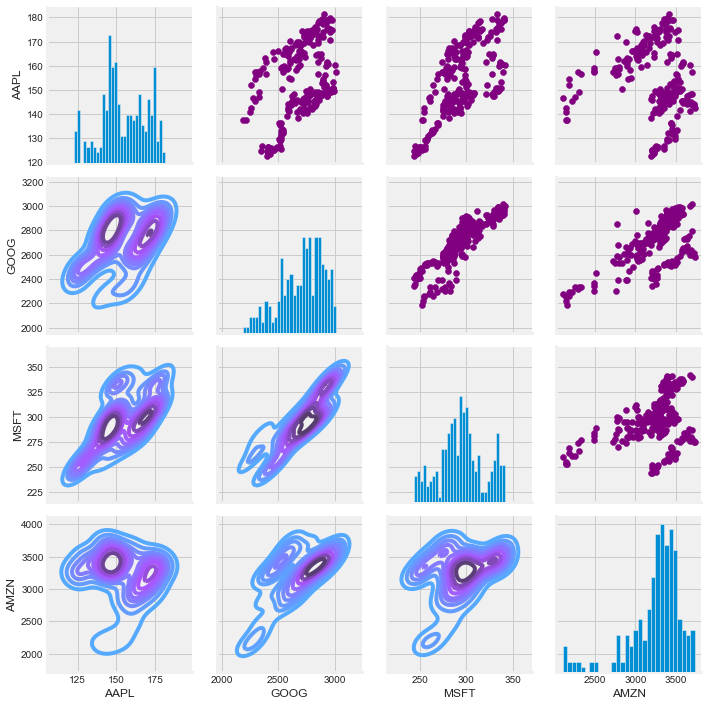

In [36]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Finally, we could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting relationship between Microsoft and Apple.

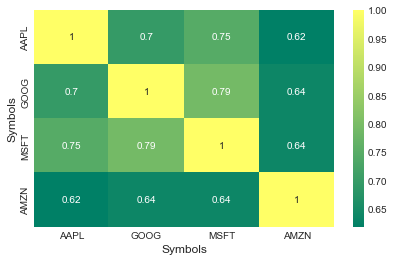

In [37]:
# Let's go ahead and use sebron for a quick correlation plot for the daily returns
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')

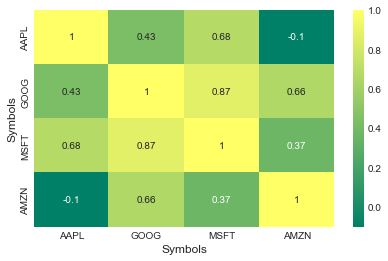

In [38]:
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')

Fantastic! Just like we suspected in our PairPlot we see here numerically and visually that Microsoft and Amazon had the strongest correlation of daily stock return. It's also interesting to see that all the technology comapnies are positively correlated.

# 5. How much value do we put at risk by investing in a particular stock?

There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

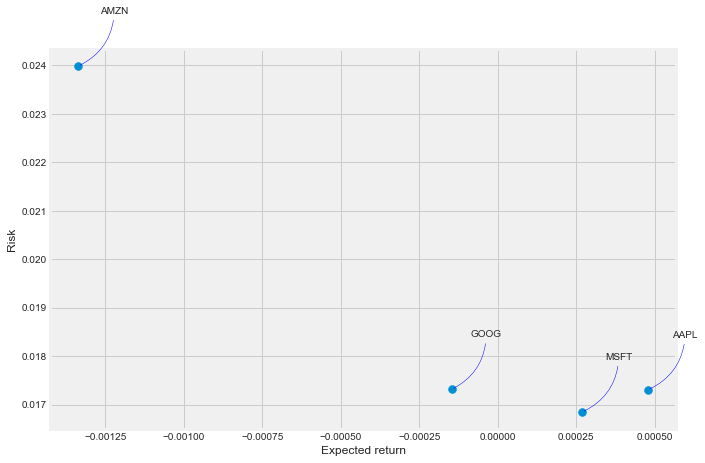

In [39]:
# Let's start by defining a new DataFrame as a clenaed version of the oriignal tech_rets DataFrame
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 7))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

# 6. Predicting the closing price stock price of APPLE inc:

In [40]:
# Get the stock quote
df = DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=datetime.now())
# Show teh data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.557466
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.624949
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.765109
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.898553
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.878098
...,...,...,...,...,...,...
2022-05-16,147.520004,144.179993,145.550003,145.539993,86643800.0,145.539993
2022-05-17,149.770004,146.679993,148.860001,149.240005,78336300.0,149.240005
2022-05-18,147.360001,139.899994,146.850006,140.820007,109742900.0,140.820007


In [41]:
df_nintendo

,Date,SecuritiesCode,Open,High,Low,Close,AdjustmentFactor,Volume
1202045,2019-08-01,7974,40430.0,41810.0,40360.0,41440.0,1.0,2402000
1203990,2019-08-02,7974,40840.0,40980.0,39840.0,40290.0,1.0,2278200
1205935,2019-08-05,7974,39790.0,39850.0,38840.0,39330.0,1.0,1499700
1207880,2019-08-06,7974,37730.0,39010.0,37660.0,38940.0,1.0,1792000
1209825,2019-08-07,7974,39330.0,39430.0,38830.0,39180.0,1.0,1231600
...,...,...,...,...,...,...,...,...
2324046,2021-11-29,7974,50180.0,52040.0,50070.0,51340.0,1.0,1304100
2326046,2021-11-30,7974,51530.0,51730.0,50010.0,50100.0,1.0,1271300
2328046,2021-12-01,7974,50100.0,51400.0,49800.0,50670.0,1.0,838100
2330046,2021-12-02,7974,50740.0,51950.0,50710.0,51700.0,1.0,976500


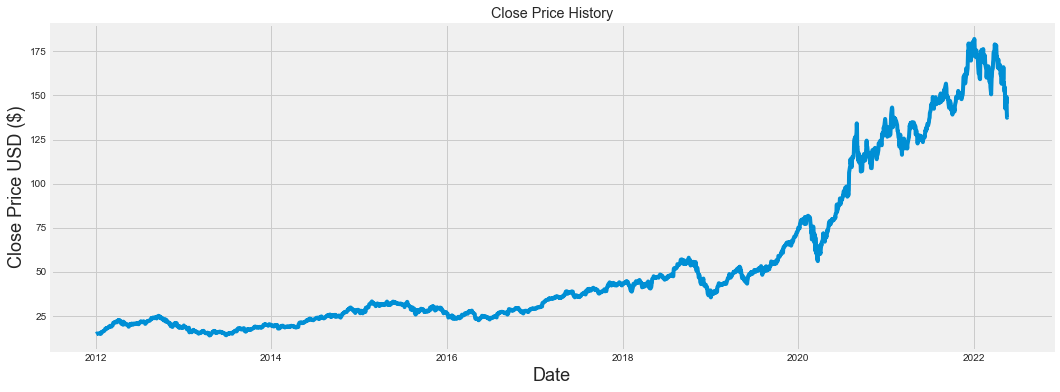

In [42]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [43]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2484

In [44]:
# Create a new dataframe with only the 'Close column 
data = df_nintendo.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

543

In [45]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.23808188],
       [0.20583287],
       [0.17891195],
       [0.16797532],
       [0.17470555],
       [0.17863152],
       [0.18199663],
       [0.15311273],
       [0.19966349],
       [0.19489624],
       [0.18984857],
       [0.1965788 ],
       [0.19798093],
       [0.20415031],
       [0.20274818],
       [0.22518228],
       [0.19265283],
       [0.20471116],
       [0.20751542],
       [0.20274818],
       [0.20583287],
       [0.2083567 ],
       [0.2125631 ],
       [0.24200785],
       [0.22462142],
       [0.23836231],
       [0.25070107],
       [0.24425126],
       [0.22854739],
       [0.24200785],
       [0.2425687 ],
       [0.25070107],
       [0.26472238],
       [0.26668536],
       [0.27706113],
       [0.26360067],
       [0.21228267],
       [0.21620864],
       [0.2083567 ],
       [0.19826136],
       [0.22349972],
       [0.2307908 ],
       [0.21144139],
       [0.22490185],
       [0.20919798],
       [0.21929333],
       [0.22265844],
       [0.206

In [46]:
# Create the training data set 
# Create the scaled training data set
num_rows = 15
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(num_rows, len(train_data)):
    x_train.append(train_data[i-num_rows:i, 0])
    y_train.append(train_data[i, 0])
    if i<= num_rows+1:
        #print(x_train)
        #print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [47]:
x_train[0]

array([[0.23808188],
       [0.20583287],
       [0.17891195],
       [0.16797532],
       [0.17470555],
       [0.17863152],
       [0.18199663],
       [0.15311273],
       [0.19966349],
       [0.19489624],
       [0.18984857],
       [0.1965788 ],
       [0.19798093],
       [0.20415031],
       [0.20274818]])

In [48]:
len(x_train[0])

15

## The previous cells created np arrays in which each element is an array with num_rolws # of elements

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

print("Using TensorFlow version %s" % tf.__version__)

Using TensorFlow version 2.5.0


In [50]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
# Create the testing data set
# Create a new array containing scaled values 

test_data = scaled_data[training_data_len - num_rows: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(num_rows, len(test_data)):
    x_test.append(test_data[i-num_rows:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

In [ ]:
# Plot the data
train = data[60:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Show the valid and predicted prices
valid